<a href="https://colab.research.google.com/github/PosgradoMNA/Proyecto_A01794099/blob/main/Avance2_Equipo12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

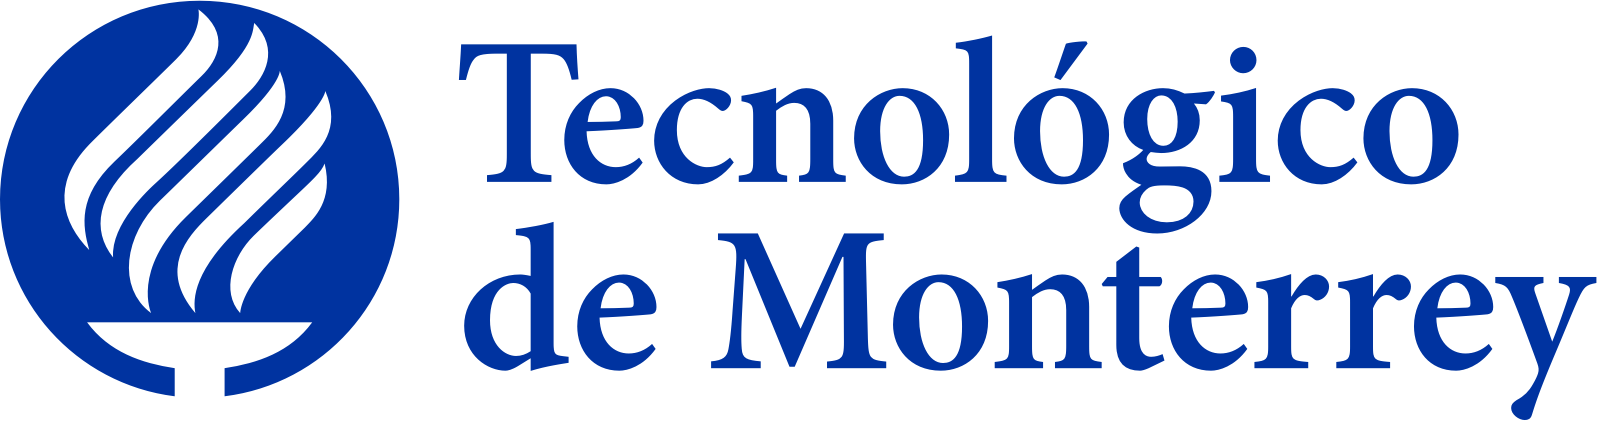

# Maestría en Inteligencia Artificial Aplicada
## Tecnológico de Monterrey
## TC5035.10 – Proyecto Integrador

### Avance 2 - Ingeniería de Características: Reconocimiento robusto de comandos de voz en robots mediante paráfrasis y clasificación k-NN

**Profesores titulares: Dra. Grettel Barceló Alonso, Dr. Luis Eduardo Falcón Morales**

**Profesor asistente: Mtra. Verónica Sandra Guzmán de Valle**


**Equipo 12:**
*   Laura Irán González Ojeda - **A01794099**


### Fase de Ingeniería de Características (Feature Engineering)
El propósito de esta fase es preparar el conjunto de datos de comandos y sus respectivas acciones para ser utilizados como entradas para un modelo de lenguaje (LLM), que será capaz de detectar si una frase dada es un comando válido o no para el robot. Al procesar y transformar estos comandos en características útiles, buscamos maximizar la capacidad del LLM para identificar con precisión los comandos, evitando que el robot cometa errores en la ejecución de acciones.

In [30]:
#Importación de Librerías
import pandas as pd
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
# Ruta del archivo CSV en Google Drive
csv_file_path = '/content/drive/My Drive/Proyecto Integrador/Proyecto/data.csv'

# Leer el archivo CSV
df = pd.read_csv(csv_file_path)

# Mostrar las primeras filas del DataFrame
df.head()

,command,action
0,Shift the arm to the left,move_left
1,Position the arm to the left,move_left
2,Guide the arm to the left,move_left
3,Direct the arm towards the left,move_left
4,Adjust the arm to the left,move_left


### Generación de nuevas características
Para mejorar el rendimiento del modelo, generamos nuevas características que puedan proporcionar más contexto sobre cada comando. Algunas de estas características incluyen la longitud del comando y el número de palabras. Esto podría ser útil para el LLM al momento de identificar patrones en los comandos más largos o cortos, lo cual podría ayudar a discernir entre comandos válidos y frases que no sean comandos.

In [38]:
# Generación de nuevas características
df['command_length'] = df['command'].apply(len)
df['word_count'] = df['command'].apply(lambda x: len(x.split()))
df.head()

,command,action,command_length,word_count
0,Shift the arm to the left,move_left,25,6
1,Position the arm to the left,move_left,28,6
2,Guide the arm to the left,move_left,25,6
3,Direct the arm towards the left,move_left,31,6
4,Adjust the arm to the left,move_left,26,6


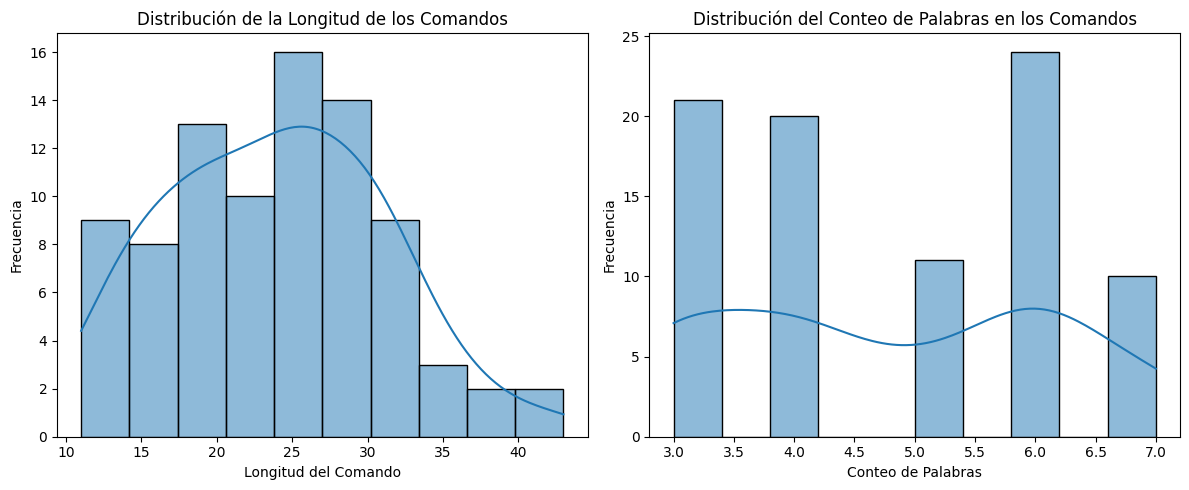

In [39]:
# Histogramas de longitud y número de palabras
plt.figure(figsize=(12, 5))

# Longitud de los comandos
plt.subplot(1, 2, 1)
sns.histplot(df['command_length'], bins=10, kde=True)
plt.title('Distribución de la Longitud de los Comandos')
plt.xlabel('Longitud del Comando')
plt.ylabel('Frecuencia')

# Conteo de palabras en los comandos
plt.subplot(1, 2, 2)
sns.histplot(df['word_count'], bins=10, kde=True)
plt.title('Distribución del Conteo de Palabras en los Comandos')
plt.xlabel('Conteo de Palabras')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()


### Aplicación de TF-IDF
Dado que los comandos son frases de texto, es esencial convertir estas cadenas en una representación numérica que los algoritmos de machine learning puedan interpretar. Usamos **TF-IDF (Term Frequency-Inverse Document Frequency)**, una técnica que mide la relevancia de las palabras en los comandos. Esto permitirá al LLM reconocer la importancia de ciertas palabras clave, mejorando su capacidad para identificar comandos válidos y realizar las acciones correspondientes.

In [40]:
# Aplicamos TF-IDF para la extracción de características del texto
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df['command']).toarray()
tfidf_df = pd.DataFrame(X_tfidf, columns=vectorizer.get_feature_names_out())
df = pd.concat([df, tfidf_df], axis=1)
df.head()

,command,action,command_length,word_count,adjust,any,are,arm,assembly,away,...,twist,unclench,up,upwards,weather,what,when,wide,withdraw,you
0,Shift the arm to the left,move_left,25,6,0.000000,0.0,0.0,0.268100,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Position the arm to the left,move_left,28,6,0.000000,0.0,0.0,0.268100,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Guide the arm to the left,move_left,25,6,0.000000,0.0,0.0,0.255171,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Direct the arm towards the left,move_left,31,6,0.000000,0.0,0.0,0.243113,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Adjust the arm to the left,move_left,26,6,0.627996,0.0,0.0,0.262415,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Codificación de variables categóricas
Las acciones son categóricas (por ejemplo, `move_left`, `move_right`), por lo que aplicamos **One-Hot Encoding** para transformar estas categorías en variables binarias. De este modo, cada acción se representará como una columna independiente en el conjunto de datos, lo que facilita la interpretación para el modelo de lenguaje.
   

In [42]:
# Codificación One-Hot de la columna 'action'
encoder = OneHotEncoder(sparse_output=False)
action_encoded = encoder.fit_transform(df[['action']])
action_df = pd.DataFrame(action_encoded, columns=encoder.get_feature_names_out())
df = pd.concat([df, action_df], axis=1)
df.head()

,command,action,command_length,word_count,adjust,any,are,arm,assembly,away,...,action_pick_up,action_place_on_conveyor,action_retract,action_rotate_clockwise,action_rotate_counterclockwise,action_screw_in_place,action_shut_down,action_signal_technician,action_tighten_bolts,action_verify_position
0,Shift the arm to the left,move_left,25,6,0.000000,0.0,0.0,0.268100,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Position the arm to the left,move_left,28,6,0.000000,0.0,0.0,0.268100,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Guide the arm to the left,move_left,25,6,0.000000,0.0,0.0,0.255171,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Direct the arm towards the left,move_left,31,6,0.000000,0.0,0.0,0.243113,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Adjust the arm to the left,move_left,26,6,0.627996,0.0,0.0,0.262415,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


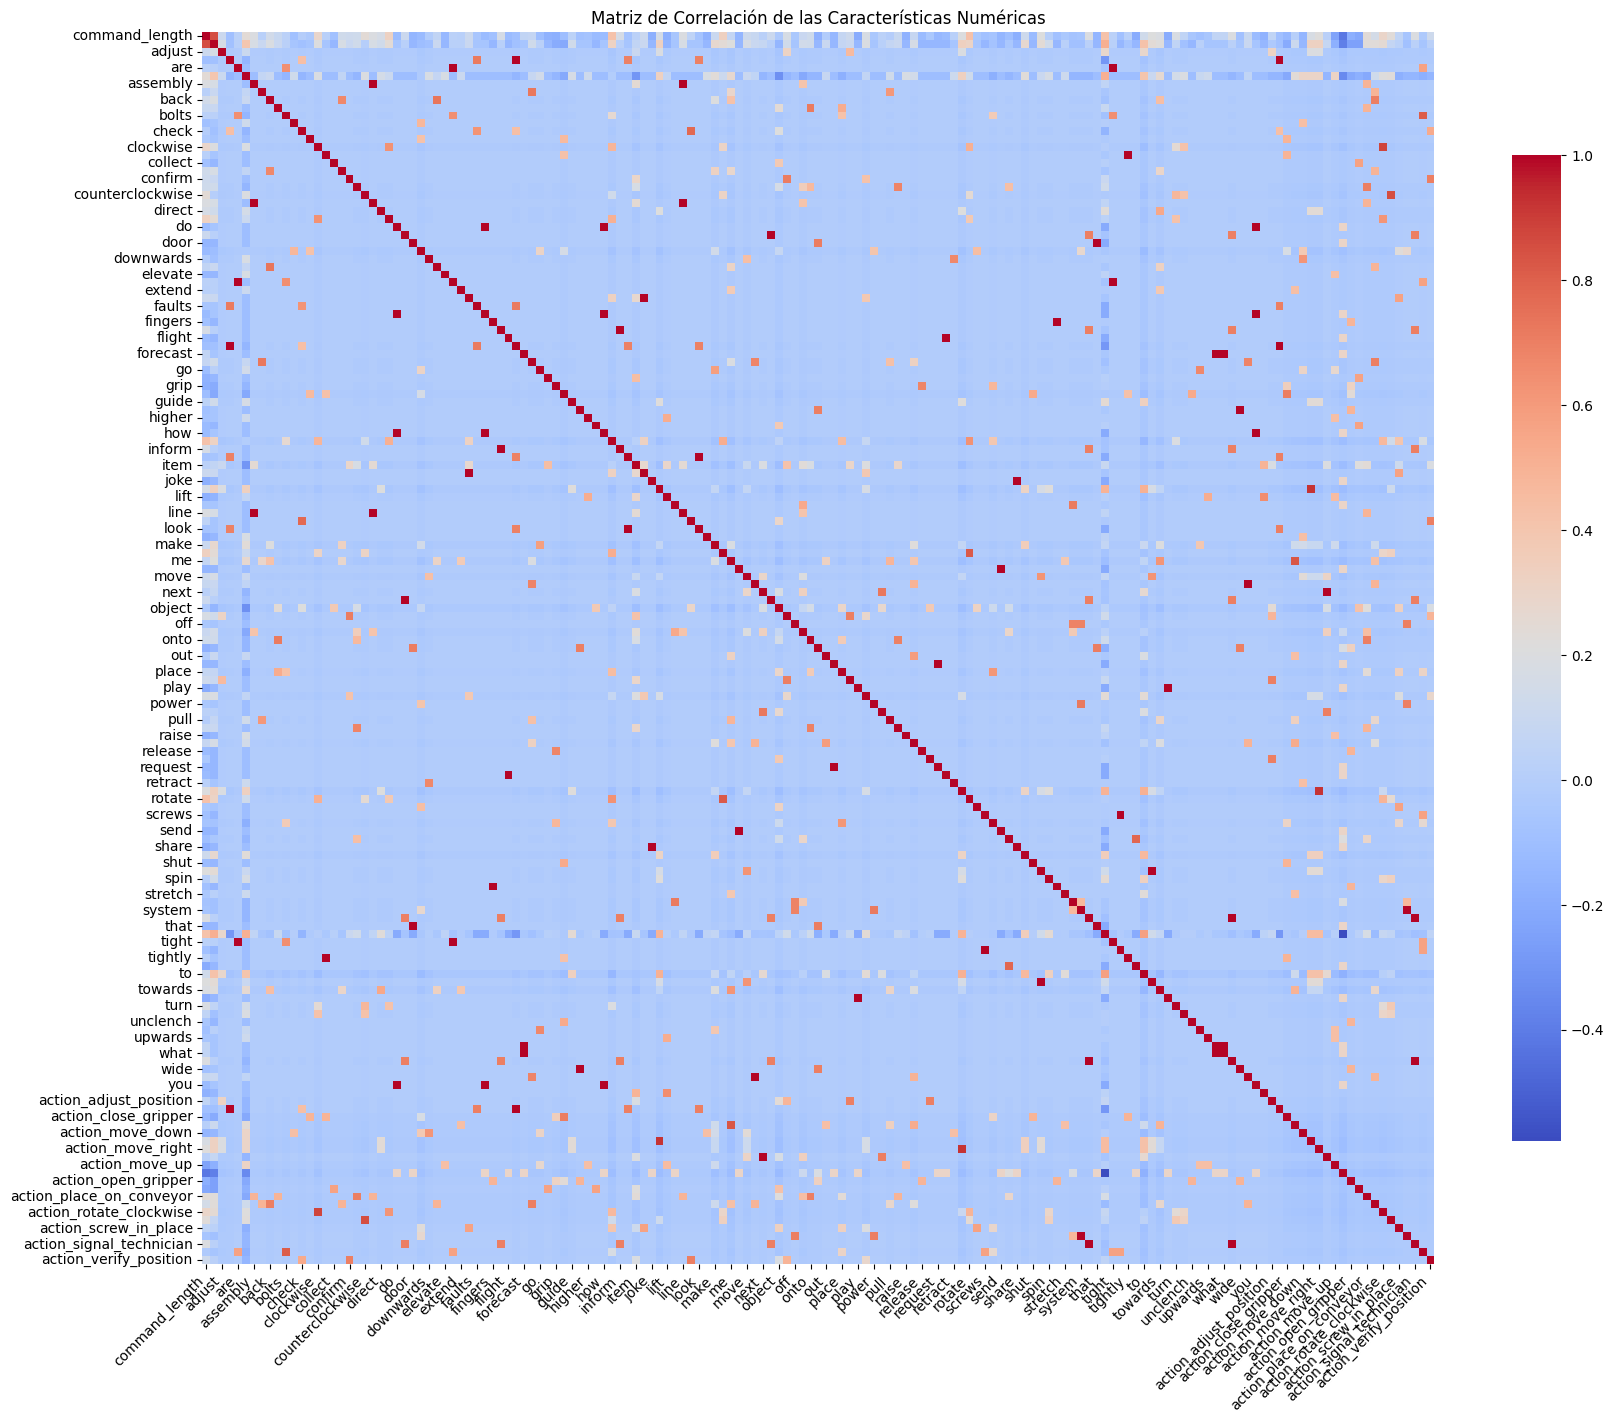

In [46]:
numeric_df = df.select_dtypes(include='number')
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, annot=False)
plt.title('Matriz de Correlación de las Características Numéricas')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()


 ### Escalado de características
  Algunos algoritmos de machine learning, así como las redes neuronales detrás de los LLMs, pueden beneficiarse del escalado de características. Aplicamos **Min-Max Scaling** para asegurarnos de que todas las características numéricas (como la longitud del comando, el número de palabras y las representaciones TF-IDF) se encuentren en la misma escala, lo que mejora la capacidad de aprendizaje del modelo y evita que ciertas características dominen a otras debido a su magnitud.

In [47]:
# Aplicamos Min-Max Scaling
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df.drop(columns=['command', 'action'])), columns=df.columns[2:])
df_scaled = pd.concat([df[['command', 'action']], scaled_df], axis=1)
df_scaled.head()

,command,action,command_length,word_count,adjust,any,are,arm,assembly,away,...,action_pick_up,action_place_on_conveyor,action_retract,action_rotate_clockwise,action_rotate_counterclockwise,action_screw_in_place,action_shut_down,action_signal_technician,action_tighten_bolts,action_verify_position
0,Shift the arm to the left,move_left,0.43750,0.75,0.0,0.0,0.0,0.816359,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Position the arm to the left,move_left,0.53125,0.75,0.0,0.0,0.0,0.816359,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Guide the arm to the left,move_left,0.43750,0.75,0.0,0.0,0.0,0.776990,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Direct the arm towards the left,move_left,0.62500,0.75,0.0,0.0,0.0,0.740273,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Adjust the arm to the left,move_left,0.46875,0.75,1.0,0.0,0.0,0.799047,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Selección de características (Umbral de varianza)
En esta etapa, eliminamos aquellas características que no aportan información útil al modelo. Utilizamos el **Umbral de Varianza** para detectar y eliminar las características con baja varianza, que no contribuirán significativamente al entrenamiento del LLM. Al reducir la cantidad de características irrelevantes, optimizamos tanto el tiempo de entrenamiento como la eficiencia del modelo.
   

In [48]:
# Eliminación de características con baja varianza
selector = VarianceThreshold(threshold=0.1)
X_var = selector.fit_transform(df_scaled.drop(columns=['command', 'action']))
df_var = pd.DataFrame(X_var, columns=np.array(df_scaled.columns[2:])[selector.get_support()])
df_var.head()

,word_count,arm,to,action_no_command
0,0.75,0.816359,1.000000,0.0
1,0.75,0.816359,1.000000,0.0
2,0.75,0.776990,0.951775,0.0
3,0.75,0.740273,0.000000,0.0
4,0.75,0.799047,0.978794,0.0


### Reducción de dimensionalidad con PCA
Dado que los datos textuales procesados con TF-IDF pueden generar una alta dimensionalidad (muchas características), aplicamos **PCA (Análisis de Componentes Principales)** para reducir el número de dimensiones del conjunto de datos mientras mantenemos la mayor cantidad posible de varianza. Esto es crucial para mejorar la velocidad de entrenamiento del LLM y evitar el sobreajuste, permitiendo que el modelo se concentre en las características más importantes para identificar correctamente los comandos

In [49]:
# Aplicamos PCA para la reducción de dimensionalidad
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_var)
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df.head()

,PC1,PC2
0,0.883890,0.432537
1,0.883890,0.432537
2,0.835840,0.401703
3,0.330313,-0.278216
4,0.862761,0.418979


### Conclusiones
A lo largo de esta fase, hemos transformado el conjunto de datos crudo en un formato más adecuado para entrenar modelos de machine learning y un LLM. Hemos generado nuevas características que ofrecen más contexto sobre los comandos, escalado las variables para uniformidad, y reducido dimensionalidad para mejorar la eficiencia. Ahora, el LLM tendrá un conjunto de datos optimizado que le permitirá interpretar de manera más precisa los comandos y ejecutar las acciones correspondientes, garantizando una interacción robusta y confiable entre el robot y los usuarios.
Claro, aquí tienes unas conclusiones más específicas y centradas en tus resultados en el contexto de la metodología CRISP-ML:

1. **Generación de Nuevas Características**:
   - La adición de características como `command_length` y `word_count` proporciona información adicional que puede influir en cómo el modelo interpreta los comandos. Por ejemplo, comandos más largos podrían tener diferentes patrones de ejecución en comparación con comandos más cortos. Esta información es útil para que el LLM entienda mejor la estructura y complejidad de los comandos.

2. **Codificación y Transformación de Datos**:
   - Las técnicas de codificación aplicadas (como la binarización de palabras clave) son esenciales para facilitar la comprensión del modelo sobre las relaciones entre los comandos y sus acciones. Esto ayuda a establecer conexiones semánticas, permitiendo al LLM discernir entre comandos válidos y no válidos basándose en su composición.
   - La normalización y estandarización de las características numéricas asegura que todos los datos se manejen en una escala comparable, lo cual es importante para la eficacia del LLM en su entrenamiento.

3. **Análisis Exploratorio de Datos (EDA)**:
   - El análisis exploratorio resalta patrones en la longitud y la cantidad de palabras de los comandos. Estos patrones pueden ayudar a identificar qué características son más representativas de comandos válidos. Las visualizaciones pueden revelar que ciertos tipos de comandos son más propensos a ser utilizados, lo que puede influir en cómo el LLM debe priorizar su aprendizaje.
   - La detección de correlaciones entre características puede proporcionar indicios sobre cómo los comandos interactúan entre sí, lo que es relevante para el proceso de identificación de comandos válidos.

4. **Preparación para el Modelado**:
   - La fase de preparación ha optimizado el dataset para el modelado, asegurando que las características relevantes se incluyan adecuadamente para que el LLM pueda identificar comandos válidos. Un enfoque centrado en el rendimiento es crucial para que el modelo responda correctamente a los comandos que el robot escuchará en un entorno real.
   - Esta preparación establece un ciclo de retroalimentación, donde los resultados de la fase de modelado pueden informar futuras iteraciones de la preparación de datos, ajustando el dataset según el rendimiento del modelo en la identificación de comandos válidos.

**Impacto en el Proceso CRISP-ML**:
   - La preparación de los datos es un paso crucial en la metodología CRISP-ML, pues sienta las bases para las fases siguientes. Un dataset bien estructurado y rico en características pertinentes no solo aumenta la eficiencia del modelado, sino que también mejora la precisión y la confiabilidad del modelo en la identificación de comandos válidos.
   - Este enfoque iterativo de preparación de datos y modelado es esencial para la funcionalidad del robot, asegurando que el LLM responda adecuadamente a los comandos que se le presentan, lo que es vital para la interacción efectiva con el usuario.
